# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

### *** YOUR EMAILS HERE ***

ariel.rabinovitch@post.runi.ac.il
erel.vanono@post.runi.ac.il

## Please sign that you have read and understood the instructions:

### *** YOUR IDS HERE ***

315871939
314804568


In [4]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique designed to embed high-dimensional data into a lower-dimensional space (typically 2D or 3D), while preserving the local structure of the data. It is especially useful for visualization tasks.

The core idea is to convert pairwise similarities between data points into probabilities, both in the high-dimensional space and in the lower-dimensional space, and then minimize the Kullback-Leibler (KL) divergence between these two distributions.

The algorithm proceeds in three main stages:

##### Stage 1: Compute Pairwise Similarities in High Dimensions

For each data point ​​$x_i$, we model the conditional probability ​$p_{i|j}$ that ​$x_i$ would pick ​$x_j$ as its neighbor, using a Gaussian distribution centered at ​$x_i$.

The bandwidth (standard deviation) of this Gaussian is determined via perplexity, a hyperparameter that controls the effective number of neighbors.

We then symmetrize the probabilities using:

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

##### Stage 2: Compute Pairwise Similarities in Low Dimensions

We initialize the low-dimensional representations ​$y_i$ randomly.

Pairwise similarities ​​$q_{ij}$ between points ​$y_i$ and $y_j$ are computed using a Student t-distribution with one degree of freedom:

$$q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \ne l} (1 + \|y_k - y_l\|^2)^{-1}}$$

##### Stage 3: Optimize via Gradient Descent

We minimize the Kullback-Leibler divergence between the high-dimensional and low-dimensional similarity distributions:

$$KL(P \| Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$$


## Hyperparameters

- Perplexity: Controls local neighborhood size in high-dimensional space; typically between 5 and 50.

- Learning rate: Affects the step size during gradient descent.

- Number of iterations: Total optimization steps, usually a few hundred to a few thousand.

- Initialization: Usually with small random values or PCA-reduced space.


### Optimization Strategy

We use *gradient descent* to minimize the KL divergence. To improve convergence:

### Limitations

- Poor performance in preserving global structure of data.

- Non-parametric: doesn't naturally support adding new data points

### Use-Cases

- Visualizing clusters in high-dimensional data (e.g., MNIST, word embeddings).

- Exploratory data analysis where interpretability of local relationships is critical.

- Understanding structure in embeddings from neural networks or feature spaces.


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [14]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.X = None
        self.Y = None
        self.P = None  # High-dimensional similarities
        
    def _compute_pairwise_distances(self, X):
        """Compute pairwise Euclidean distances between points."""
        sum_X = np.sum(np.square(X), axis=1)
        D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        return D
    
    def _binary_search_perplexity(self, distances, perplexity, tol=1e-5, max_iter=50):
        n = distances.shape[0]
        P = np.zeros((n, n))
        log_perp = np.log(perplexity)
        for i in range(n):
            beta = 1.0
            beta_min = -np.inf
            beta_max = np.inf
            Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
            H, thisP = self._Hbeta(Di, beta)
            Hdiff = H - log_perp
            tries = 0
            while np.abs(Hdiff) > tol and tries < max_iter:
                if Hdiff > 0:
                    beta_min = beta
                    if beta_max == np.inf or beta_max == -np.inf:
                        beta *= 2
                    else:
                        beta = (beta + beta_max) / 2
                else:
                    beta_max = beta
                    if beta_min == -np.inf or beta_min == np.inf:
                        beta /= 2
                    else:
                        beta = (beta + beta_min) / 2
                H, thisP = self._Hbeta(Di, beta)
                Hdiff = H - log_perp
                tries += 1
            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
        return P

    def _Hbeta(self, D, beta):
        P = np.exp(-D * beta)
        sumP = np.sum(P)
        if sumP == 0:
            sumP = 1e-10
        H = np.log(sumP) + beta * np.sum(D * P) / sumP
        P = P / sumP
        return H, P
    
    def _compute_high_dim_similarities(self, X):
        """Compute pairwise similarities in high-dimensional space."""
        distances = self._compute_pairwise_distances(X)
        P = self._binary_search_perplexity(distances, self.perplexity)
        # Symmetrize the probabilities
        P = (P + P.T) / (2 * P.shape[0])
        return P
    
    def _compute_low_dim_similarities(self, Y):
        """Compute pairwise similarities in low-dimensional space using t-distribution."""
        distances = self._compute_pairwise_distances(Y)
        Q = 1 / (1 + distances)
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q)
        return Q
    
    def _compute_gradient(self, Y, P, Q):
        """Compute gradient of KL divergence with respect to Y."""
        n = Y.shape[0]
        dY = np.zeros((n, self.n_components))
        
        # Vectorized gradient computation
        for i in range(n):
            # Compute differences between point i and all other points
            diff = Y[i] - Y  # Shape: (n, n_components)
            # Compute squared distances
            dist_sq = np.sum(diff**2, axis=1)  # Shape: (n,)
            # Compute the gradient contribution from all points
            grad = 4 * (P[i] - Q[i])[:, np.newaxis] * diff / (1 + dist_sq)[:, np.newaxis]
            # Sum up all contributions
            dY[i] = np.sum(grad, axis=0)
            
        return dY
    
    def fit_transform(self, X):
        """Fit t-SNE to the data and return the transformed data."""
        self.X = X
        n = X.shape[0]
        
        print("Computing high-dimensional similarities...")
        # Step 1: Compute high-dimensional similarities
        self.P = self._compute_high_dim_similarities(X)
        
        # Initialize Y randomly
        self.Y = np.random.randn(n, self.n_components) * 1e-4
        
        print("Starting gradient descent...")
        # Gradient descent
        for i in range(self.n_iter):
            if i % 100 == 0:  # Print progress every 100 iterations
                print(f"Iteration {i}/{self.n_iter}")
                
            # Compute low-dimensional similarities
            Q = self._compute_low_dim_similarities(self.Y)
            
            # Compute gradient
            dY = self._compute_gradient(self.Y, self.P, Q)
            
            # Update Y
            self.Y = self.Y - self.learning_rate * dY
            
            # Center Y
            self.Y = self.Y - np.mean(self.Y, axis=0)
        
        print("t-SNE completed!")
        return self.Y
    
    def transform(self, X_original, Y_original, X_new):
        """Transform new data points into the existing t-SNE layout."""
        # Compute distances between new points and original points
        distances = np.zeros((X_new.shape[0], X_original.shape[0]))
        for i in range(X_new.shape[0]):
            distances[i] = np.sum((X_original - X_new[i])**2, axis=1)
        
        # Compute similarities using t-distribution
        similarities = 1 / (1 + distances)
        
        # Weighted average of original points' positions
        Y_new = np.zeros((X_new.shape[0], self.n_components))
        for i in range(X_new.shape[0]):
            weights = similarities[i] / np.sum(similarities[i])
            Y_new[i] = np.sum(Y_original * weights[:, np.newaxis], axis=0)
            
        return Y_new

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We choosed to used the MNSIT dataset for the following resons:
1. It is high dimensional dataset (784 dimensions, 28 X 28 pixels)
2. Has clear class structure (10 digits)

Training set shape: (4000, 784)
Test set shape: (1000, 784)


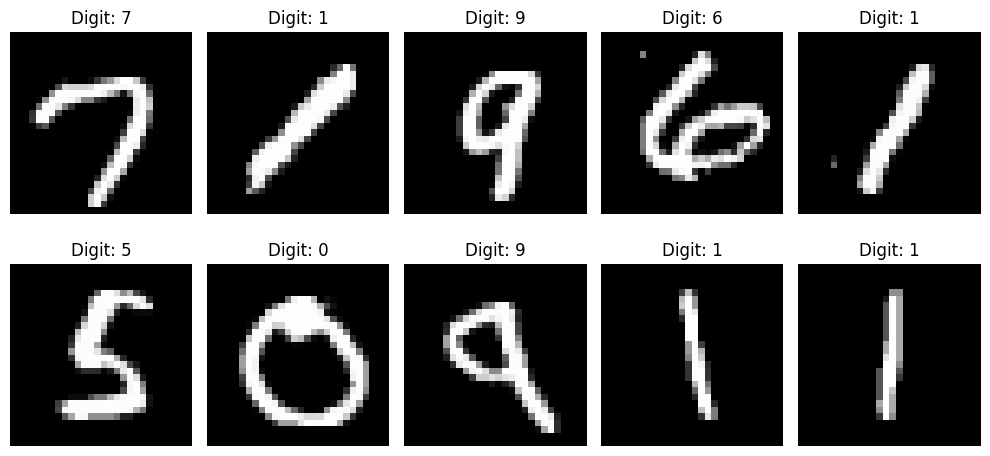

In [15]:
# Load data
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32')
y = y.astype('int')

# Normalize data if necessary
X = (X - X.min()) / (X.max() - X.min()) # Min-Max

# Split the data into train and test
n_samples = 5000  # Using 5000 samples for demonstration
X = X[:n_samples]
y = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


# Visualize some sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Digit: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

Computing high-dimensional similarities...
Starting gradient descent...
Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000
t-SNE completed!


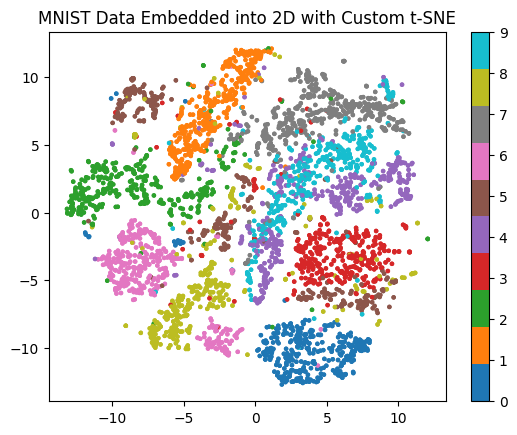

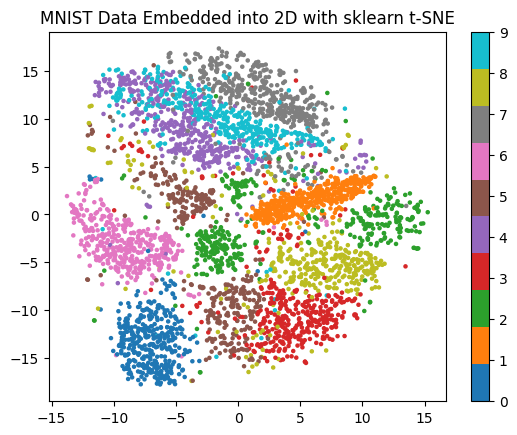

In [16]:
# Run your custom t-SNE implementation
# Initialize and run custom t-SNE
custom_tsne = CustomTSNE(
    perplexity=30.0,  # Typical value for MNIST
    n_components=2,   # 2D visualization
    n_iter=1000,      # Number of iterations
    learning_rate=200.0  # Learning rate for gradient descent
)

custom_Y = custom_tsne.fit_transform(X_train)

# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=4000/10)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

# t-SNE Extension: Mapping New Samples

## Approach Description

t-SNE is a non-parametric algorithm, meaning it does not learn an explicit mapping function from high-dimensional space to the low-dimensional embedding. Therefore, to map new samples into an existing t-SNE embedding, we use a similarity-based interpolation method.

### Problem Setup

Given:
- $ X \in \mathbb{R}^{n \times d} $: Original high-dimensional training data
- $ Y \in \mathbb{R}^{n \times 2} $: Corresponding 2D t-SNE embedding
- $ x_{\text{new}} \in \mathbb{R}^d$: New data point to embed

### Step 1: Compute Similarities

For each new sample $x_{\text{new}}$, compute its similarity to each training sample $x_i$ using a Student-t kernel (the same kernel used in t-SNE's low-dimensional space):

$s_i = \frac{1}{1 + \|x_{\text{new}} - x_i\|^2}$

### Step 2: Weighted Average in Embedding Space

Normalize the similarities to sum to 1:

$w_i = \frac{s_i}{\sum_{j=1}^n s_j}$

The new point's embedding $ y_{\text{new}}$ is then a weighted average of the training embeddings:

$y_{\text{new}} = \sum_{i=1}^n w_i Y_i$


## Summary

- This method allows you to project new data points into an existing t-SNE visualization without retraining.
- It is efficient and preserves the local structure of the original embedding.

Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

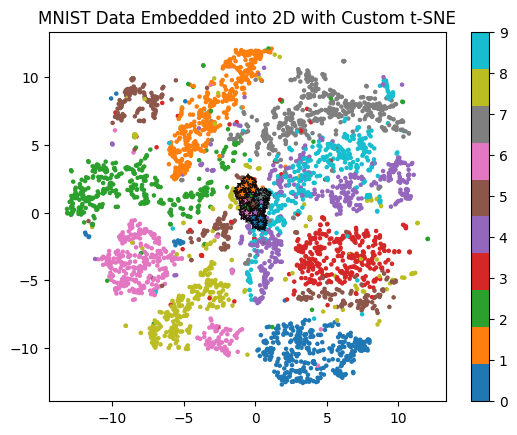

In [21]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train,custom_Y,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker='*', s=50, linewidths=0.5, edgecolors='k', c=y_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

Used Generative AI (Claude) to understand the algorithm better and consildate with it about implementation specifics 